#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.




Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
import numpy as np

def loss(X, y, w: list, w0: float, gamma=1., beta=1.) -> float:
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    w = np.asarray(w, dtype=float)

    if X.ndim != 2:
        raise ValueError("X must be a 2D array of shape (N, K).")
    N = X.shape[0]
    if y.shape[0] != N:
        raise ValueError("y must have the same number of rows as X.")
    if w.shape[0] != X.shape[1]:
        raise ValueError("w must have same length as number of columns in X.")

    unique_vals = np.unique(y)
    if set(unique_vals.tolist()).issubset({0, 1}):
        y = 2 * y - 1.0

    s = X.dot(w) + float(w0)
    yz = y * s

    loss_terms = np.logaddexp(0.0, -yz)
    logistic_loss = np.mean(loss_terms)

    l1 = gamma * np.sum(np.abs(w))
    l2 = beta * np.sum(w * w)

    return float(logistic_loss + l1 + l2)


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
import numpy as np
from typing import List, Tuple

def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    w = np.asarray(w, dtype=float)
    N = X.shape[0]

    uniq = np.unique(y)
    if set(uniq.tolist()).issubset({0, 1}):
        s = X.dot(w) + float(w0)
        denom = 1.0 + np.exp(y * s)
        common = - (y / denom)
        grad_w = (X.T @ common) / N
        grad_w0 = float(np.mean(common))
    else:
        s = X.dot(w) + float(w0)
        common = - y / (1.0 + np.exp(y * s))
        grad_w = (X.T @ common) / N
        grad_w0 = float(np.mean(common))

    grad_w = grad_w + gamma * np.sign(w) + 2.0 * beta * w

    return grad_w, grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
import numpy as np
from typing import Optional
from sklearn.base import BaseEstimator, ClassifierMixin

class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = float(beta)
        self.gamma = float(gamma)
        self.lr = float(lr)
        self.tolerance = float(tolerance)
        self.max_iter = int(max_iter)
        self.random_state = int(random_state)

        self.coef_: Optional[np.ndarray] = None
        self.intercept_: float = 0.0
        self.n_iter_: int = 0
        self.is_fitted_: bool = False
        self.loss_history_: list = []

    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n_samples, n_features = X.shape

        unique = np.unique(y)
        if set(unique.tolist()).issubset({-1, 1}):
            y_bin = (y == 1).astype(float)
        else:
            y_bin = y.copy()

        rng = np.random.RandomState(self.random_state)
        self.coef_ = rng.normal(scale=0.01, size=n_features)
        self.intercept_ = 0.0

        self.loss_history_ = []

        for epoch in range(1, self.max_iter + 1):
            perm = rng.permutation(n_samples)
            max_change = 0.0

            for idx in perm:
                xi = X[idx]
                yi = y_bin[idx]
                s = np.dot(xi, self.coef_) + self.intercept_
                pred = self._sigmoid(s)

                grad_w = xi * (pred - yi)
                grad_w0 = (pred - yi)

                grad_w += self.gamma * np.sign(self.coef_) + 2.0 * self.beta * self.coef_

                delta_w = -self.lr * grad_w
                delta_w0 = -self.lr * grad_w0
                self.coef_ += delta_w
                self.intercept_ += delta_w0

                max_change = max(max_change, np.max(np.abs(delta_w)), abs(delta_w0))

            s_full = X @ self.coef_ + self.intercept_
            pred_full = self._sigmoid(s_full)

            log_likelihood = np.sum(y_bin * np.log(pred_full + 1e-15) + (1 - y_bin) * np.log(1 - pred_full + 1e-15))
            l1_penalty = self.gamma * np.sum(np.abs(self.coef_))
            l2_penalty = self.beta * np.sum(self.coef_ ** 2)
            loss = -log_likelihood + l1_penalty + l2_penalty
            self.loss_history_.append(loss)

            self.n_iter_ = epoch
            if max_change < self.tolerance:
                break

        self.is_fitted_ = True
        return self

    def predict_proba(self, X):
        if not self.is_fitted_:
            raise ValueError("Модель не обучена.")
        X = np.asarray(X, dtype=float)
        s = X.dot(self.coef_) + float(self.intercept_)
        return self._sigmoid(s)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs >= 0.5).astype(int)


def plot_loss_history(model):
    if not hasattr(model, 'loss_history_'):
        raise ValueError("Model has no loss history. Ensure the model was fitted with loss tracking enabled.")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(model.loss_history_) + 1), model.loss_history_, marker='o', markersize=4)
    plt.title("Loss Function Value Over Iterations")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
def plot_decision_boundary(model, X, y, ax=None, grid_step=0.02, margin=0.5):

    X = np.asarray(X)
    y = np.asarray(y)

    if X.shape[1] != 2:
        raise ValueError("plot_decision_boundary supports only 2D features (shape (_,2)).")

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    x_min, x_max = X[:,0].min() - margin, X[:,0].max() + margin
    y_min, y_max = X[:,1].min() - margin, X[:,1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    grid = np.c_[xx.ravel(), yy.ravel()]

    probs = model.predict_proba(grid)
    Z = probs.reshape(xx.shape)

    contour = ax.contourf(xx, yy, Z, levels=25, alpha=0.6)

    ax.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors='k')

    y_plot = y.copy()
    if set(np.unique(y_plot).tolist()).issubset({0,1}):
        y_plot = 2*y_plot - 1
    pos_idx = (y_plot == 1)
    neg_idx = (y_plot == -1)

    ax.scatter(X[pos_idx,0], X[pos_idx,1], marker='o', edgecolor='k', s=60, label='class +1')
    ax.scatter(X[neg_idx,0], X[neg_idx,1], marker='s', edgecolor='k', s=60, label='class -1')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()
    ax.set_title("Decision boundary and probability contour")
    plt.show()

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    if not hasattr(model, 'loss_history_'):
        raise ValueError("Model has no loss history. Ensure the model was fitted with loss tracking enabled.")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(model.loss_history_) + 1), model.loss_history_, marker='o', markersize=4)
    plt.title("Loss Function Value Over Iterations")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

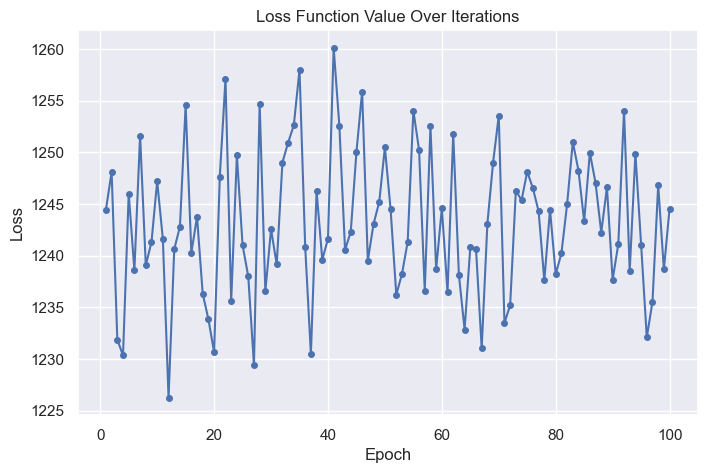

In [ ]:
model = Logit(beta=1.0, gamma=1.0, lr=1e-2, max_iter=100)
model.fit(X, y)
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10, 100]

results = []

for kernel in kernels:
    for C in C_values:
        svc = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        svc.fit(X_train, y_train)

        y_pred = svc.predict(X_test)
        y_proba = svc.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba)

        results.append({
            'kernel': kernel,
            'C': C,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'AUC-ROC': auc
        })

results_df = pd.DataFrame(results)
print(results_df)

best_f1 = results_df.sort_values(by='F1-Score', ascending=False).head(10)
print("\nЛучшие 10 результатов по F1-Score:")
print(best_f1)

     kernel      C  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0    linear    0.1  0.997222   0.994286  1.000000  0.997135  0.999815
1    linear    1.0  0.997222   0.994286  1.000000  0.997135  0.999351
2    linear   10.0  0.997222   0.994286  1.000000  0.997135  0.998795
3    linear  100.0  0.997222   0.994286  1.000000  0.997135  0.998795
4      poly    0.1  0.997222   0.994286  1.000000  0.997135  0.996261
5      poly    1.0  0.997222   0.994286  1.000000  0.997135  0.997683
6      poly   10.0  0.997222   0.994286  1.000000  0.997135  0.998548
7      poly  100.0  0.997222   0.994286  1.000000  0.997135  0.998610
8       rbf    0.1  0.997222   0.994286  1.000000  0.997135  1.000000
9       rbf    1.0  0.997222   0.994286  1.000000  0.997135  0.999815
10      rbf   10.0  0.997222   0.994286  1.000000  0.997135  0.996570
11      rbf  100.0  0.997222   0.994286  1.000000  0.997135  0.995056
12  sigmoid    0.1  0.905556   0.864583  0.954023  0.907104  0.981214
13  sigmoid    1.0  

#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [ ]:
from typing import Optional
from sklearn.base import BaseEstimator, ClassifierMixin

class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=1e-2, C=1.0, tolerance=1e-6, max_iter=1000, random_state=42):
        self.lr = float(lr)
        self.C = float(C)
        self.tolerance = float(tolerance)
        self.max_iter = int(max_iter)
        self.random_state = int(random_state)

        self.coef_: Optional[np.ndarray] = None
        self.intercept_: float = 0.0
        self.n_iter_: int = 0
        self.is_fitted_: bool = False

    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n_samples, n_features = X.shape

        y_hinge = 2 * y - 1

        rng = np.random.RandomState(self.random_state)
        self.coef_ = rng.normal(scale=0.01, size=n_features)
        self.intercept_ = 0.0

        for epoch in range(1, self.max_iter + 1):
            s = X @ self.coef_ + self.intercept_
            margins = y_hinge * s
            mask = margins < 1

            grad_w = np.zeros_like(self.coef_)
            grad_w += 2.0 / self.C * self.coef_
            grad_w -= np.sum((mask * y_hinge).reshape(-1, 1) * X, axis=0)

            grad_b = -np.sum(mask * y_hinge)

            self.coef_ -= self.lr * grad_w
            self.intercept_ -= self.lr * grad_b

            change = max(np.max(np.abs(self.lr * grad_w)), abs(self.lr * grad_b))
            self.n_iter_ = epoch
            if change < self.tolerance:
                break

        self.is_fitted_ = True
        return self

    def decision_function(self, X):
        if not self.is_fitted_:
            raise ValueError("Модель не обучена.")
        X = np.asarray(X, dtype=float)
        return X @ self.coef_ + float(self.intercept_)

    def predict(self, X):
        scores = self.decision_function(X)
        return (scores >= 0).astype(int)

    def predict_proba(self, X):
        scores = self.decision_function(X)
        prob_1 = self._sigmoid(scores)
        prob_0 = 1 - prob_1
        return np.vstack([prob_0, prob_1]).T

In [ ]:
clf = HingeLossClassifier(lr=1e-2, C=1.0, max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

y_test_binary = (y_test == 1).astype(int)

acc = accuracy_score(y_test_binary, y_pred)
prec = precision_score(y_test_binary, y_pred, pos_label=1, average='binary', zero_division=0)
rec = recall_score(y_test_binary, y_pred, pos_label=1, average='binary', zero_division=0)
f1 = f1_score(y_test_binary, y_pred, pos_label=1, average='binary', zero_division=0)
auc = roc_auc_score(y_test_binary, y_proba)

metrics = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC-ROC': auc
}

print("Метрики HingeLossClassifier:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Метрики HingeLossClassifier:
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
F1-Score: 0.9971
AUC-ROC: 0.9952


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train: Optional[np.ndarray] = None
        self.y_train: Optional[np.ndarray] = None
        self.classes_: Optional[np.ndarray] = None
        self.is_fitted_: bool = False

    def fit(self, X, y):
        self.X_train = np.asarray(X, dtype=float)
        self.y_train = np.asarray(y, dtype=int)
        self.classes_ = np.unique(self.y_train)
        self.is_fitted_ = True
        return self

    def _compute_distances(self, X):
        if self.metric == 'euclidean':
            # (n_test, n_train)
            return np.sqrt(np.sum((X[:, None, :] - self.X_train[None, :, :]) ** 2, axis=2))
        else:
            raise NotImplementedError(f"Metric '{self.metric}' is not implemented.")

    def predict(self, X):
        if not self.is_fitted_:
            raise ValueError("Model is not fitted.")
        X = np.asarray(X, dtype=float)

        distances = self._compute_distances(X)
        n_test = distances.shape[0]
        y_pred = []

        for i in range(n_test):
            k_indices = np.argpartition(distances[i], self.n_neighbors)[:self.n_neighbors]
            k_labels = self.y_train[k_indices]
            most_common = Counter(k_labels).most_common(1)[0][0]
            y_pred.append(most_common)

        return np.array(y_pred)

    def predict_proba(self, X):
        if not self.is_fitted_:
            raise ValueError("Model is not fitted.")
        X = np.asarray(X, dtype=float)

        distances = self._compute_distances(X)
        n_test = distances.shape[0]
        n_classes = len(self.classes_)
        y_proba = []

        for i in range(n_test):
            k_indices = np.argpartition(distances[i], self.n_neighbors)[:self.n_neighbors]
            k_labels = self.y_train[k_indices]

            counts = Counter(k_labels)
            proba = np.array([counts.get(cls, 0) for cls in self.classes_], dtype=float)
            proba /= self.n_neighbors  # нормализуем
            y_proba.append(proba)

        return np.array(y_proba)

In [ ]:
knn = KNNClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

y_test_binary = np.where(y_test == -1, 0, 1)
y_pred_binary = np.where(y_pred == -1, 0, 1)

y_proba = knn.predict_proba(X_test)
if len(knn.classes_) == 2:
    y_proba_positive = y_proba[:, 1]
else:
    y_proba_positive = y_proba[:, 1]
acc = accuracy_score(y_test_binary, y_pred_binary)
prec = precision_score(y_test_binary, y_pred_binary, pos_label=1, average='binary', zero_division=0)
rec = recall_score(y_test_binary, y_pred_binary, pos_label=1, average='binary', zero_division=0)
f1 = f1_score(y_test_binary, y_pred_binary, pos_label=1, average='binary', zero_division=0)
auc = roc_auc_score(y_test_binary, y_proba_positive)

metrics = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC-ROC': auc
}

print("Метрики KNNClassifier:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Метрики KNNClassifier:
Accuracy: 0.9972
Precision: 0.9943
Recall: 1.0000
F1-Score: 0.9971
AUC-ROC: 0.9973


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
import pandas as pd
import numpy as np

# Загружаем датасет
df = pd.read_csv("fashion-mnist.csv")

print(df.shape)
df.head()

X = df.drop(columns=["label"]).values
y = df["label"].values

# Делим выборку
X_train, y_train = X[:50000], y[:50000]
X_test, y_test = X[50000:], y[50000:]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


(60000, 785)
Train size: (50000, 784), Test size: (10000, 784)


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

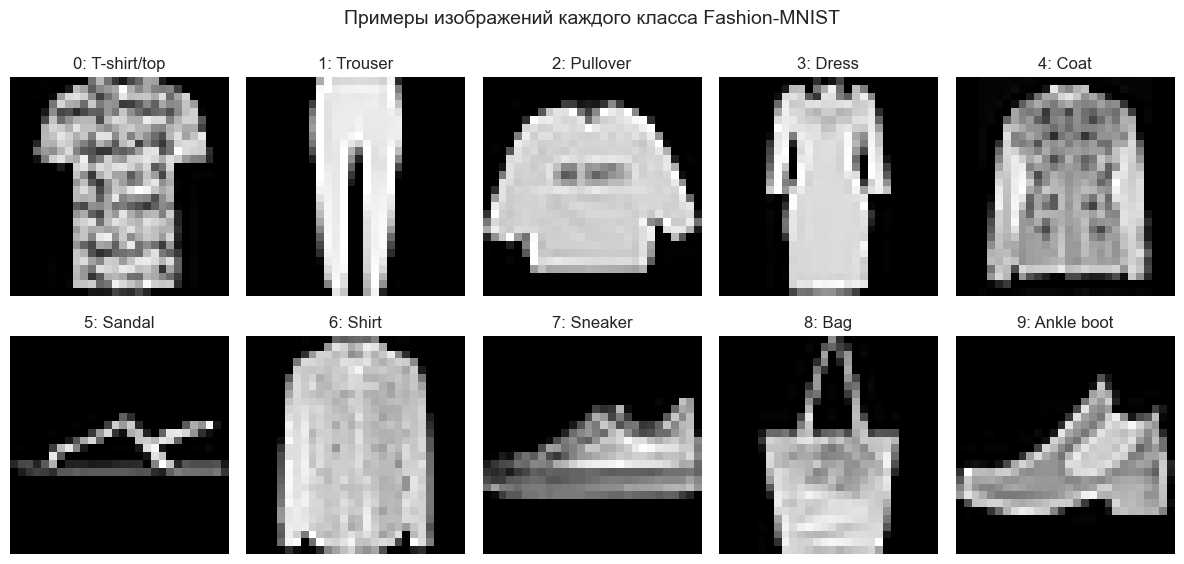

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Названия классов Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Определяем уникальные метки
unique_labels = np.unique(y_train)

plt.figure(figsize=(12, 6))
for i, label in enumerate(unique_labels):
    # Находим индекс первого объекта данного класса
    idx = np.where(y_train == label)[0][0]
    image = X_train[idx].reshape(28, 28)

    # Визуализация
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"{label}: {class_names[label]}")
    plt.axis('off')

plt.suptitle("Примеры изображений каждого класса Fashion-MNIST", fontsize=14)
plt.tight_layout()
plt.show()


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


scaler_standard = StandardScaler()
X_train_std = scaler_standard.fit_transform(X_train)
X_test_std = scaler_standard.transform(X_test)


scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

print("После StandardScaler:")
print(f"  Среднее: {X_train_std.mean():.4f}, Ст. отклонение: {X_train_std.std():.4f}")
print("\nПосле MinMaxScaler:")
print(f"  Мин: {X_train_minmax.min():.4f}, Макс: {X_train_minmax.max():.4f}")


После StandardScaler:
  Среднее: 0.0000, Ст. отклонение: 1.0000

После MinMaxScaler:
  Мин: 0.0000, Макс: 1.0000


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import time
import numpy as np
from scipy.stats import loguniform
import joblib



# Используем стандартизированные данные
X_train_lr, X_test_lr = X_train_std, X_test_std
X_train_knn, X_test_knn = X_train_minmax, X_test_minmax


print("\n Настройка KNeighborsClassifier")
print("-" * 40)

start_knn = time.time()

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan', 'euclidean']
}

knn_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    knn_params,
    n_iter=8,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

knn_search.fit(X_train_knn, y_train)
knn_best = knn_search.best_estimator_

knn_time = time.time() - start_knn
print(f" KNN настроен за {knn_time:.2f} сек")
print(f" Лучшие параметры KNN: {knn_search.best_params_}")

knn_pred = knn_best.predict(X_test_knn)
knn_acc = accuracy_score(y_test, knn_pred)
print(f" Accuracy KNN: {knn_acc:.4f}")


print("\n УСКОРЕННАЯ настройка LogisticRegression")
print("-" * 50)

start_lr = time.time()

print(" Быстрый поиск параметров на уменьшенной выборке...")

sample_size = min(5000, len(X_train_lr))
indices = np.random.RandomState(42).choice(len(X_train_lr), sample_size, replace=False)
X_train_lr_fast = X_train_lr[indices]
y_train_lr_fast = y_train[indices]

# ОПТИМИЗАЦИЯ: Используем только совместимые комбинации параметров
lr_params_fast = [
    # Для L2 регуляризации
    {
        'C': loguniform(1e-3, 1e2),
        'penalty': ['l2'],
        'solver': ['lbfgs', 'newton-cg'],
        'max_iter': [200, 300],
        'tol': [1e-3, 1e-4]
    },
    # Для L1 регуляризации
    {
        'C': loguniform(1e-3, 1e2),
        'penalty': ['l1'],
        'solver': ['liblinear'],
        'max_iter': [200, 300],
        'tol': [1e-3, 1e-4]
    }
]

lr_search_fast = RandomizedSearchCV(
    LogisticRegression(random_state=42),
    lr_params_fast,
    n_iter=6,  # Очень мало итераций для скорости
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

lr_search_fast.fit(X_train_lr_fast, y_train_lr_fast)
fast_params = lr_search_fast.best_params_

print(f" Быстрый поиск завершён за {time.time() - start_lr:.2f} сек")
print(f" Предварительные параметры: {fast_params}")

# Точная настройка на полной выборке с узким диапазоном
print("\n Точная настройка на полной выборке...")

# Создаем узкую сетку вокруг лучших параметров из быстрого поиска
best_C = fast_params['C']
best_penalty = fast_params['penalty']
best_solver = fast_params['solver']

# Определяем узкий диапазон для C
if best_C <= 0.1:
    C_range = np.logspace(np.log10(best_C/2), np.log10(best_C*2), 4)
else:
    C_range = [best_C/2, best_C/1.5, best_C, best_C*1.5, best_C*2]

lr_params_final = {
    'C': C_range,
    'penalty': [best_penalty],
    'solver': [best_solver],
    'max_iter': [500, 1000],  # Увеличиваем итерации для точности
    'tol': [1e-4]  # Более строгий допуск
}

if best_penalty == 'l2' and best_solver in ['lbfgs', 'newton-cg']:
    lr_params_final['max_iter'] = [1000, 1500]

lr_final = LogisticRegression(random_state=42)

# Используем GridSearchCV с маленькой сеткой
lr_search_final = RandomizedSearchCV(
    lr_final,
    lr_params_final,
    n_iter=4,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

lr_search_final.fit(X_train_lr, y_train)
lr_best = lr_search_final.best_estimator_

lr_time = time.time() - start_lr
print(f" Полная настройка LogisticRegression завершена за {lr_time:.2f} сек")
print(f" Финальные параметры: {lr_search_final.best_params_}")

lr_pred = lr_best.predict(X_test_lr)
lr_acc = accuracy_score(y_test, lr_pred)
print(f" Accuracy LogisticRegression: {lr_acc:.4f}")


print("\n АЛЬТЕРНАТИВА: Ускоренная LogisticRegression")
print("-" * 50)

start_lr_very_fast = time.time()

# Используем проверенные параметры, которые обычно хорошо работают
lr_very_fast = LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

lr_very_fast.fit(X_train_lr, y_train)

lr_very_fast_time = time.time() - start_lr_very_fast
print(f" Супер-быстрая LogisticRegression обучена за {lr_very_fast_time:.2f} сек")

lr_very_fast_pred = lr_very_fast.predict(X_test_lr)
lr_very_fast_acc = accuracy_score(y_test, lr_very_fast_pred)
print(f" Accuracy супер-быстрой LogisticRegression: {lr_very_fast_acc:.4f}")


print(f"\n СРАВНЕНИЕ ВАРИАНТОВ LOGISTICREGRESSION:")
print(f"   • Полная настройка: {lr_acc:.4f} (время: {lr_time:.2f} сек)")
print(f"   • Быстрая версия:  {lr_very_fast_acc:.4f} (время: {lr_very_fast_time:.2f} сек)")

if lr_acc > lr_very_fast_acc + 0.005:  # Если выигрыш больше 0.5%
    best_lr = lr_best
    best_lr_acc = lr_acc
    best_lr_type = "полная настройка"
    print(" Выбрана модель с полной настройкой (значительное улучшение)")
else:
    best_lr = lr_very_fast
    best_lr_acc = lr_very_fast_acc
    best_lr_type = "быстрая версия"
    print(" Выбрана быстрая версия (незначительная разница в качестве)")

# ======================
# ФИНАЛЬНОЕ СРАВНЕНИЕ С KNN
# ======================

print("\n" + "=" * 60)
print(" ФИНАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 60)

print(f"\n ВРЕМЯ ОБУЧЕНИЯ:")
print(f"   • KNN: {knn_time:.2f} сек")
print(f"   • LogisticRegression ({best_lr_type}): {lr_time if best_lr_type == 'полная настройка' else lr_very_fast_time:.2f} сек")

print(f"\n ТОЧНОСТЬ:")
print(f"   • KNN: {knn_acc:.4f}")
print(f"   • LogisticRegression: {best_lr_acc:.4f}")

difference = knn_acc - best_lr_acc
if abs(difference) < 0.01:
    print(f"\n  Модели показывают схожее качество (разница: {abs(difference):.4f})")
elif knn_acc > best_lr_acc:
    improvement = ((knn_acc - best_lr_acc) / best_lr_acc) * 100
    print(f"\n ЛУЧШАЯ МОДЕЛЬ: KNN")
    print(f"    Преимущество: +{improvement:.2f}%")
    print(f"    KNN лучше улавливает сложные нелинейные границы в данных изображений")
else:
    improvement = ((best_lr_acc - knn_acc) / knn_acc) * 100
    print(f"\n ЛУЧШАЯ МОДЕЛЬ: LogisticRegression")
    print(f"    Преимущество: +{improvement:.2f}%")
    print(f"    LogisticRegression лучше обобщает и быстрее предсказывает")

# ======================
# ДЕТАЛЬНЫЙ АНАЛИЗ
# ======================

print(f"\n ДЕТАЛЬНАЯ СТАТИСТИКА ЛУЧШЕЙ МОДЕЛИ LOGISTICREGRESSION:")
print(classification_report(y_test, best_lr.predict(X_test_lr), digits=4))

print(f"\n ДЕТАЛЬНАЯ СТАТИСТИКА KNN:")
print(classification_report(y_test, knn_pred, digits=4))

# ======================
# СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
# ======================

print(f"\n СОХРАНЕНИЕ МОДЕЛЕЙ...")

joblib.dump(knn_best, 'knn_model.pkl')
joblib.dump(best_lr, 'best_lr_model.pkl')

if knn_acc > best_lr_acc:
    joblib.dump(knn_best, 'best_overall_model.pkl')
    print("Лучшая общая модель (KNN) сохранена")
else:
    joblib.dump(best_lr, 'best_overall_model.pkl')
    print(" Лучшая общая модель (LogisticRegression) сохранена")

print(f"\n ПАРАМЕТРЫ ЛУЧШЕЙ LOGISTICREGRESSION:")
print(f"   {best_lr.get_params()}")

print(f"\n ОПТИМИЗАЦИЯ ЗАВЕРШЕНА!")
print(f"   Общее время: {knn_time + (lr_time if best_lr_type == 'полная настройка' else lr_very_fast_time):.2f} сек")

 ЗАПУСК УСКОРЕННОЙ ОПТИМИЗАЦИИ С LOGISTICREGRESSION

 Настройка KNeighborsClassifier
----------------------------------------
Fitting 3 folds for each of 8 candidates, totalling 24 fits
 KNN настроен за 473.80 сек
 Лучшие параметры KNN: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}
 Accuracy KNN: 0.8621

 УСКОРЕННАЯ настройка LogisticRegression
--------------------------------------------------
 Быстрый поиск параметров на уменьшенной выборке...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
 Быстрый поиск завершён за 1701.19 сек
 Предварительные параметры: {'C': 0.19780827689353775, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0001}

 Точная настройка на полной выборке...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Полная настройка LogisticRegression завершена за 2007.99 сек
 Финальные параметры: {'tol': 0.0001, 'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1500, 'C': 0.09890413844676887}
 Accuracy LogisticReg

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Создаём данные: все признаки одинаковые
n_samples = 10_000
X = np.ones((n_samples, 2))  # все признаки одинаковые
y = np.array([0]*5000 + [1]*5000)  # сбалансированные классы

# Обучаем логистическую регрессию на SGD
model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
model.fit(X, y)

# Предсказания
y_pred = model.predict(X)
probs = model.predict_proba(X)[:, 1]

# Проверим параметры и результаты
print("Весовые коэффициенты модели:", model.coef_)
print("Свободный член (intercept):", model.intercept_)
print("Первые 5 предсказанных вероятностей:", probs[:5])
print("Accuracy на тренировочных данных:", accuracy_score(y, y_pred))


'''
Модель не сможет обучиться, потому что данные не содержат информации, позволяющей различать классы.
SGD не найдёт направления, куда двигать веса, и остановится вблизи нуля.
Результат — все предсказания одинаковые, качество ≈ 50%.
'''

Весовые коэффициенты модели: [[-0.00954676 -0.00954676]]
Свободный член (intercept): [-0.00938978]
Первые 5 предсказанных вероятностей: [0.49287966 0.49287966 0.49287966 0.49287966 0.49287966]
Accuracy на тренировочных данных: 0.5


'\nМодель не сможет обучиться, потому что данные не содержат информации, позволяющей различать классы.\nSGD не найдёт направления, куда двигать веса, и остановится вблизи нуля.\nРезультат — все предсказания одинаковые, качество ≈ 50%.\n'